<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/notanumber-lab1/Lab1/notanumber_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations**
**Ludwig Karlsson**, from template by **Johan Hoffman**

# **Abstract**



This short report looks at using use FEniCS to solve the Stokes equations, and as written as part of the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

Purely viscous flow ($Re\ll1$) around a small cylinder in a plane is modelled in a plane (2D) using Stokes equation. The problem is solved using the finite element method (FEM) with Taylor-Hood mixed element approximation spaces. The mesh is refined around the cylinder to approve accuracy. The method gives physically expected results. Stability of the Taylor-Hood elements is experimentally shown to hold for this problem and mesh, while equal order (1) interpolation is shown to be unstable. Finally the boundary conditions are changed to reverse the flow.

[DD2365 course website.](https://kth.instructure.com/courses/17071)


# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 

The **aim** of this lab assignment is to:
1. Change the computational domain into a channel with only one circular hole at the center of the cannel.
2. Change the mesh resolution to a uniform size of h=1/32 with a one step local refinement in a circle of radius 1 around the obstruction.
3. Experimentally verify that the Taylor-Hood mixed element is stable, whereas the equal-order element choice is unstable.
4. Switch the inflow- and outflow boundaries so that the fluid flows from right to left while investigating how the pressure changes.


# **Method**

**Define domain and mesh**

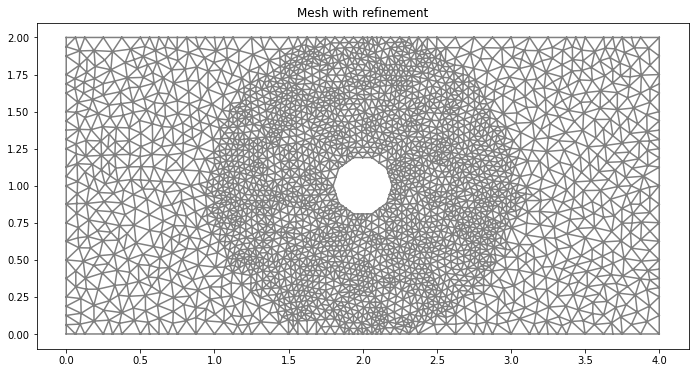

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5,0.5*H),0.2), resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L, 0.5*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0, no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure(figsize=(12, 6))
plot(mesh, title="Mesh with refinement")
plt.show()

**Define finite element approximation spaces**

In [ ]:
# use this toggle to switch between equal order elements (true) or Taylor-Hood
# elements (false)
unstable_solver = False

# use this toggle to switch position of inflow/outflow boundary
reversed_bc = True

# Generate mixed finite element spaces (for velocity and pressure)
if unstable_solver:
  VE = VectorElement("CG", mesh.ufl_cell(), 1)
else:
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions**

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element()) # these just pick out
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) # the boundary points
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

#### **The Domain** (1)

The domain was changed into a channel with a single circular hole in its center.

#### **The Mesh** (2)

The mesh resolution was set to h=1/32, and the mesh was refined once in a circle centered around the obstruction. The resulting mesh can be seen in the figure below:

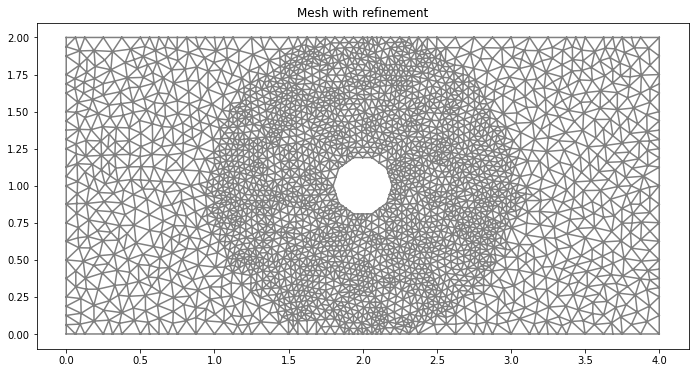

#### **The inf-sup Condution** (3)

The problem was solved using Taylor-Hood elements, and the stable solution can be seen below:

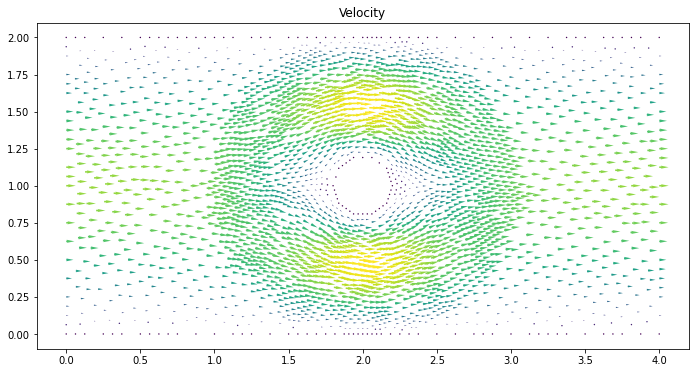

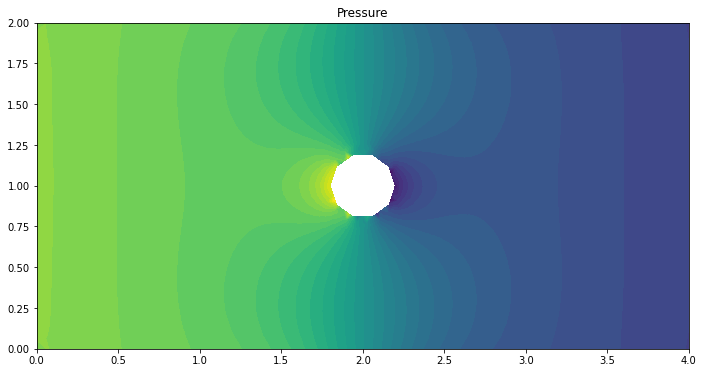

The elements were then changed to be of equal order, and the problem was solved using this unstable choice of elements. The pressure of the unstable solution can be seen below:

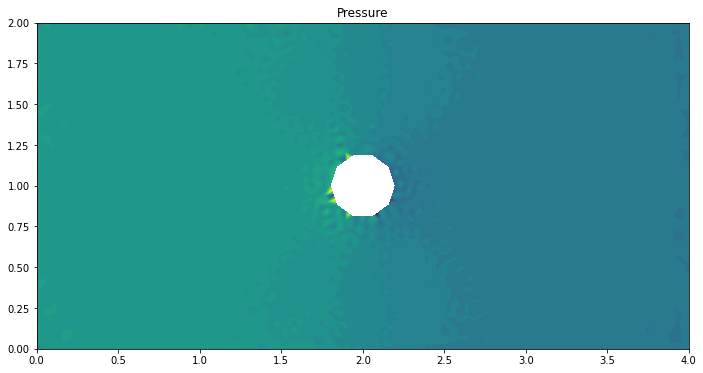

The instability manifests as large unphysical oscillations in the solution.

#### **Boundary Conditions** (4)

The inflow- and outflow boundary conditions were switched. This required modifying the boundary terms in the variational formulation by switching the inflow- and the outflow boundaries, as well as reversing the sign of the boundary condition of the inflow (negative sign such that the fluid flows from the right). The solution can be seen below:

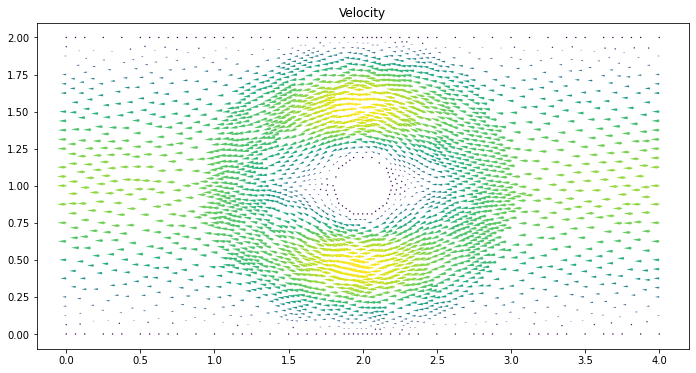

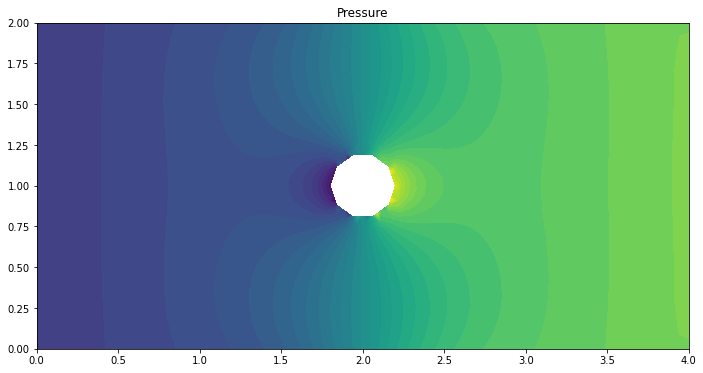

The solution looks exactly as in the previous simulations, except that the flow direction is reversed, and the pressure gradient is reversed.


**Define and solve variational problem**

In [ ]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
if reversed_bc:
  residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
              gamma*(ob*inner(u + uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )
else:
  residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
              gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w) 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


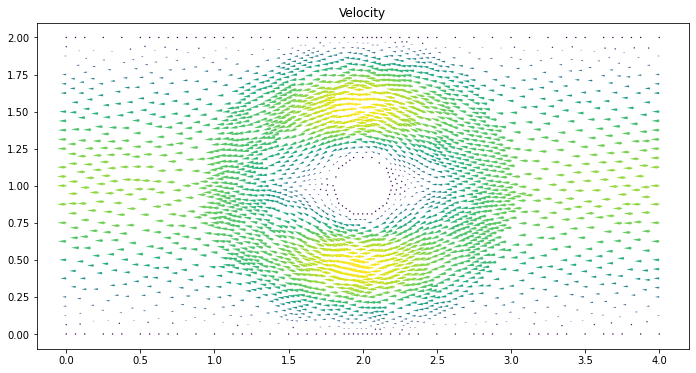

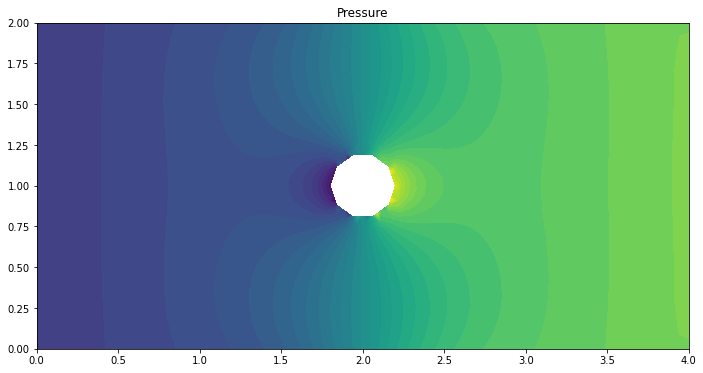

In [ ]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

# Plot solution
plt.figure(figsize=(12, 6))
plot(u1, title="Velocity", headwidth=2)

plt.figure(figsize=(12, 6))
plot(p1, title="Pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a single circular obstacle in the center of the channel. The grid was refined close to the obstacle. The solution behaved as expected. When an unstable element space was choosen, the solution showed errors in the form of unphysical oscillations. The boundary conditions were also modified to reverse the flow, and the reversed flow solution behaved exactly as the original solution except reversed, as would be expected.